### Import stats dependencies

In [1]:
import pandas as pd
import numpy as np

### Load the data, little tidy and view first few records

In [2]:
seasons = ['20172018','20152016', '20142015', '20132014', '20122013', '20112012', '20102011', '20092010', '20082009', '20072008', '20062007', '20052006', '20042005']

result_list = []
for season in seasons:
    file = 'https://www.footballwebpages.co.uk/files/archives/' + season + '.csv'
    print('Loading ' + file)
    dfResults = pd.read_csv(file)
    dfResults['Season'] = season
    result_list.append(dfResults)
    
dfResults = pd.concat(result_list)

Loading https://www.footballwebpages.co.uk/files/archives/20172018.csv
Loading https://www.footballwebpages.co.uk/files/archives/20152016.csv
Loading https://www.footballwebpages.co.uk/files/archives/20142015.csv
Loading https://www.footballwebpages.co.uk/files/archives/20132014.csv
Loading https://www.footballwebpages.co.uk/files/archives/20122013.csv
Loading https://www.footballwebpages.co.uk/files/archives/20112012.csv
Loading https://www.footballwebpages.co.uk/files/archives/20102011.csv
Loading https://www.footballwebpages.co.uk/files/archives/20092010.csv
Loading https://www.footballwebpages.co.uk/files/archives/20082009.csv
Loading https://www.footballwebpages.co.uk/files/archives/20072008.csv
Loading https://www.footballwebpages.co.uk/files/archives/20062007.csv
Loading https://www.footballwebpages.co.uk/files/archives/20052006.csv
Loading https://www.footballwebpages.co.uk/files/archives/20042005.csv


In [3]:
dfResults.drop(dfResults[dfResults['Round'].notnull()].index, inplace=True)
dfResults['Result'] = dfResults.apply(lambda x: 'H' if x['Home Score'] > x['Away Score'] else ('D' if x['Home Score'] == x['Away Score'] else 'A'), axis=1)
dfResults.head()

,Competition,Round,Date/Time,Home Team,Home Score,Away Score,Away Team,Attendance,Season,Result
0,Premier League,NaN,2017-08-11 19:45:00,Arsenal,4,3,Leicester City,59387.0,20172018,H
1,Premier League,NaN,2017-08-12 12:30:00,Watford,3,3,Liverpool,20407.0,20172018,D
2,Premier League,NaN,2017-08-12 15:00:00,Chelsea,2,3,Burnley,41616.0,20172018,A
3,Premier League,NaN,2017-08-12 15:00:00,Crystal Palace,0,3,Huddersfield Town,25448.0,20172018,A
4,Premier League,NaN,2017-08-12 15:00:00,Everton,1,0,Stoke City,39045.0,20172018,H


### Check fixtures per competition and ensure there's a good variety

In [4]:
dfResults.groupby(['Competition', 'Season']).size()

Competition                                 Season  
Bank of Scotland Scottish Division One      20042005    174
Bank of Scotland Scottish Division Three    20042005    172
Bank of Scotland Scottish Division Two      20042005    177
Bank of Scotland Scottish Premier League    20042005    222
                                            20052006    222
                                            20062007    225
                                            20072008    214
                                            20082009     93
                                            20092010    222
Barclays Premier League                     20102011    380
                                            20112012    380
                                            20122013    380
                                            20132014    380
                                            20142015    380
                                            20152016    380
Barclays Premiership                        200

### Grab unique competitions and seasons

In [5]:
comps = [list(i) for i in dfResults[['Competition', 'Season']].values]
comps = np.unique(np.array(comps), axis=0)

### Create a very basic league table formula and assume bottom three are relegated

In [6]:
def calculate_league_table(results):
    try:
        table = {}
        for team in dfSeasonResults['Home Team'].unique():
            table[team] = {
                'P': 0,
                'W': 0,
                'D': 0,
                'L': 0,
                'F': 0,
                'A': 0,
                'Pts': 0
            }
        for index, result in results.iterrows():
            table[result['Home Team']]['P'] += 1
            table[result['Away Team']]['P'] += 1
            table[result['Home Team']]['F'] += result['Home Score']
            table[result['Home Team']]['A'] += result['Away Score']
            table[result['Away Team']]['A'] += result['Home Score']
            table[result['Away Team']]['F'] += result['Away Score']
            if result['Result'] == 'H':
                table[result['Home Team']]['W'] += 1
                table[result['Home Team']]['Pts'] += 3
                table[result['Away Team']]['L'] += 1
            if result['Result'] == 'A':
                table[result['Away Team']]['W'] += 1
                table[result['Away Team']]['Pts'] += 3
                table[result['Home Team']]['L'] += 1
            if result['Result'] == 'D':
                table[result['Home Team']]['D'] += 1
                table[result['Away Team']]['D'] += 1
                table[result['Home Team']]['Pts'] += 1
                table[result['Away Team']]['Pts'] += 1

        table = pd.DataFrame.from_dict(table, orient='index')
        table['GD'] = table['F'] - table['A']

        table['PPG'] = table['Pts'] / table['P']
        table['GDPG'] = table['GD'] / table['P']
        table['GFPG'] = table['F'] / table['P']
        table['GAPG'] = table['A'] / table['P']
        table = table.sort_values(['PPG', 'GDPG'], ascending=[False, False])
        table['PPG_top'] = table.iloc[0]['PPG']
        table['PPG_bottom'] = table.iloc[-1]['PPG']
        table['PPG_std'] = table.loc[:,"PPG"].std()
        table['Relegated'] = 0
        table.iloc[-3:, table.columns.get_loc('Relegated')] = 1
        return table
    except:
        return pd.DataFrame()
    
# dfSeasonResults = dfResults[(dfResults['Competition'] == 'Sky Bet League One') & (dfResults['Season'] == '20152016')]
# table = calculate_league_table(dfSeasonResults)

tables = []
for comp in comps:
   dfSeasonResults = dfResults[(dfResults['Competition'] == comp[0]) & (dfResults['Season'] == comp[1])]
   tables.append(calculate_league_table(dfSeasonResults))

Get rid of all the tables which have less than 20 matches. Likely to be cup or at least not enough pattern to learn from

In [7]:
tables = list(filter(lambda x: x.shape[0] > 20, tables))
len(tables)

184

### Create our working dataset with specific fields

In [8]:
df_teams = pd.concat(tables)
teams = df_teams[['PPG', 'GFPG', 'GAPG', 'PPG_std', 'Relegated']].values
data_size = teams.shape[1] - 1

### Import ML libs

In [9]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD,Adam
from sklearn.metrics import confusion_matrix

/Users/chris.hunt/miniconda3/envs/ml/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


### Split and create our features and labels datasets and our train/test datasets

In [10]:
X = []
relegated = []
for team in teams:
    X.append(team[0:data_size])
    relegated.append(team[data_size])
    
X=np.array(X)
y = []
for rel in relegated:
    current = np.zeros(2)
    current[int(rel)] = 1
    y.append(current)

y=np.array(y).astype(int)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

### Create and compile our model

In [12]:
model = Sequential()

model.add(Dense(10,input_shape=(data_size,),activation='tanh'))
model.add(Dense(8,activation='tanh'))
model.add(Dense(6,activation='tanh'))
model.add(Dense(2,activation='softmax'))

#model.compile(loss = 'categorical_crossentropy',optimizer=Adam(lr=0.001) , metrics = ['accuracy'] )
model.compile(loss = 'categorical_crossentropy',optimizer='adamax' , metrics = ['accuracy'] )

### Train the model and get accuracy against test data

In [13]:
model.fit(X_test, y_test, epochs=20, batch_size=5)

Epoch 1/20
1379/1379 [==============================] - 1s 394us/step - loss: 0.3776 - acc: 0.8376
Epoch 2/20
1379/1379 [==============================] - 0s 209us/step - loss: 0.2156 - acc: 0.9181
Epoch 3/20
1379/1379 [==============================] - 0s 208us/step - loss: 0.1703 - acc: 0.9275
Epoch 4/20
1379/1379 [==============================] - 0s 212us/step - loss: 0.1607 - acc: 0.9311
Epoch 5/20
1379/1379 [==============================] - 0s 229us/step - loss: 0.1535 - acc: 0.9289
Epoch 6/20
1379/1379 [==============================] - 0s 210us/step - loss: 0.1474 - acc: 0.9347
Epoch 7/20
1379/1379 [==============================] - 0s 211us/step - loss: 0.1444 - acc: 0.9369
Epoch 8/20
1379/1379 [==============================] - 0s 211us/step - loss: 0.1405 - acc: 0.9376
Epoch 9/20
1379/1379 [==============================] - 0s 237us/step - loss: 0.1342 - acc: 0.9384
Epoch 10/20
1379/1379 [==============================] - 0s 227us/step - loss: 0.1320 - acc: 0.9384
Epoch 11/

In [14]:
scores = model.evaluate(X_test, y_test)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

1379/1379 [==============================] - 0s 36us/step

acc: 95.72%


In [15]:
# saved_model_path = tf.contrib.saved_model.save_keras_model(model, ".\saved_models")

### Inspect some predictions and confusion matrix

In [16]:
predict = model.predict(X_test)

In [17]:
predict_class = list(map(lambda x: 0 if x[0] > x[1] else 1, list(predict)))
y_test_class = list(map(lambda x: 0 if x[0] > x[1] else 1, list(y_test)))

In [18]:
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


Confusion matrix, without normalization
[[1185   17]
 [  42  135]]
Normalized confusion matrix
[[0.98585691 0.01414309]
 [0.23728814 0.76271186]]


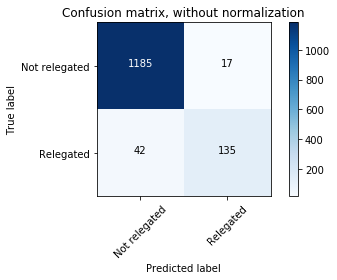

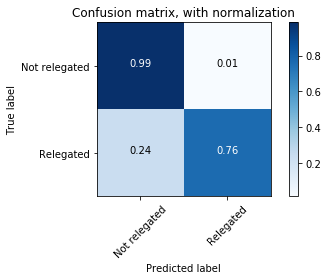

In [19]:
cm = confusion_matrix(y_test_class, predict_class, labels=[0,1])
plot_confusion_matrix(cm, classes=['Not relegated','Relegated'],
                      title='Confusion matrix, without normalization')
plt.figure()
plot_confusion_matrix(cm, classes=['Not relegated','Relegated'], normalize=True,
                      title='Confusion matrix, with normalization')

In [20]:
start = 30
end = 40
X_test[start: end]

array([[1.42857143, 1.66666667, 1.83333333, 0.42627949],
       [1.09090909, 1.34090909, 1.68181818, 0.46750506],
       [0.7826087 , 1.13043478, 2.19565217, 0.37499274],
       [1.5       , 1.41304348, 1.2173913 , 0.23062842],
       [1.84782609, 1.80434783, 1.36956522, 0.44051458],
       [2.175     , 1.925     , 1.1       , 0.36527966],
       [1.44444444, 1.48888889, 1.31111111, 0.42783611],
       [1.17073171, 1.36585366, 1.43902439, 0.42349834],
       [1.06818182, 1.40909091, 1.75      , 0.37879022],
       [1.52380952, 1.95238095, 1.35714286, 0.58877887]])

In [21]:
y_test[start: end]

array([[1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0]])

In [22]:
np.set_printoptions(suppress=True)
predict[start: end]

array([[0.9977678 , 0.00223225],
       [0.9824463 , 0.0175537 ],
       [0.04378581, 0.9562142 ],
       [0.9974317 , 0.00256827],
       [0.9993069 , 0.00069306],
       [0.9993736 , 0.00062639],
       [0.9986971 , 0.0013029 ],
       [0.99399686, 0.00600308],
       [0.9364634 , 0.06353658],
       [0.99924016, 0.0007599 ]], dtype=float32)

/Users/chris.hunt/miniconda3/envs/ml/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/chris.hunt/miniconda3/envs/ml/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/Users/chris.hunt/miniconda3/envs/ml/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


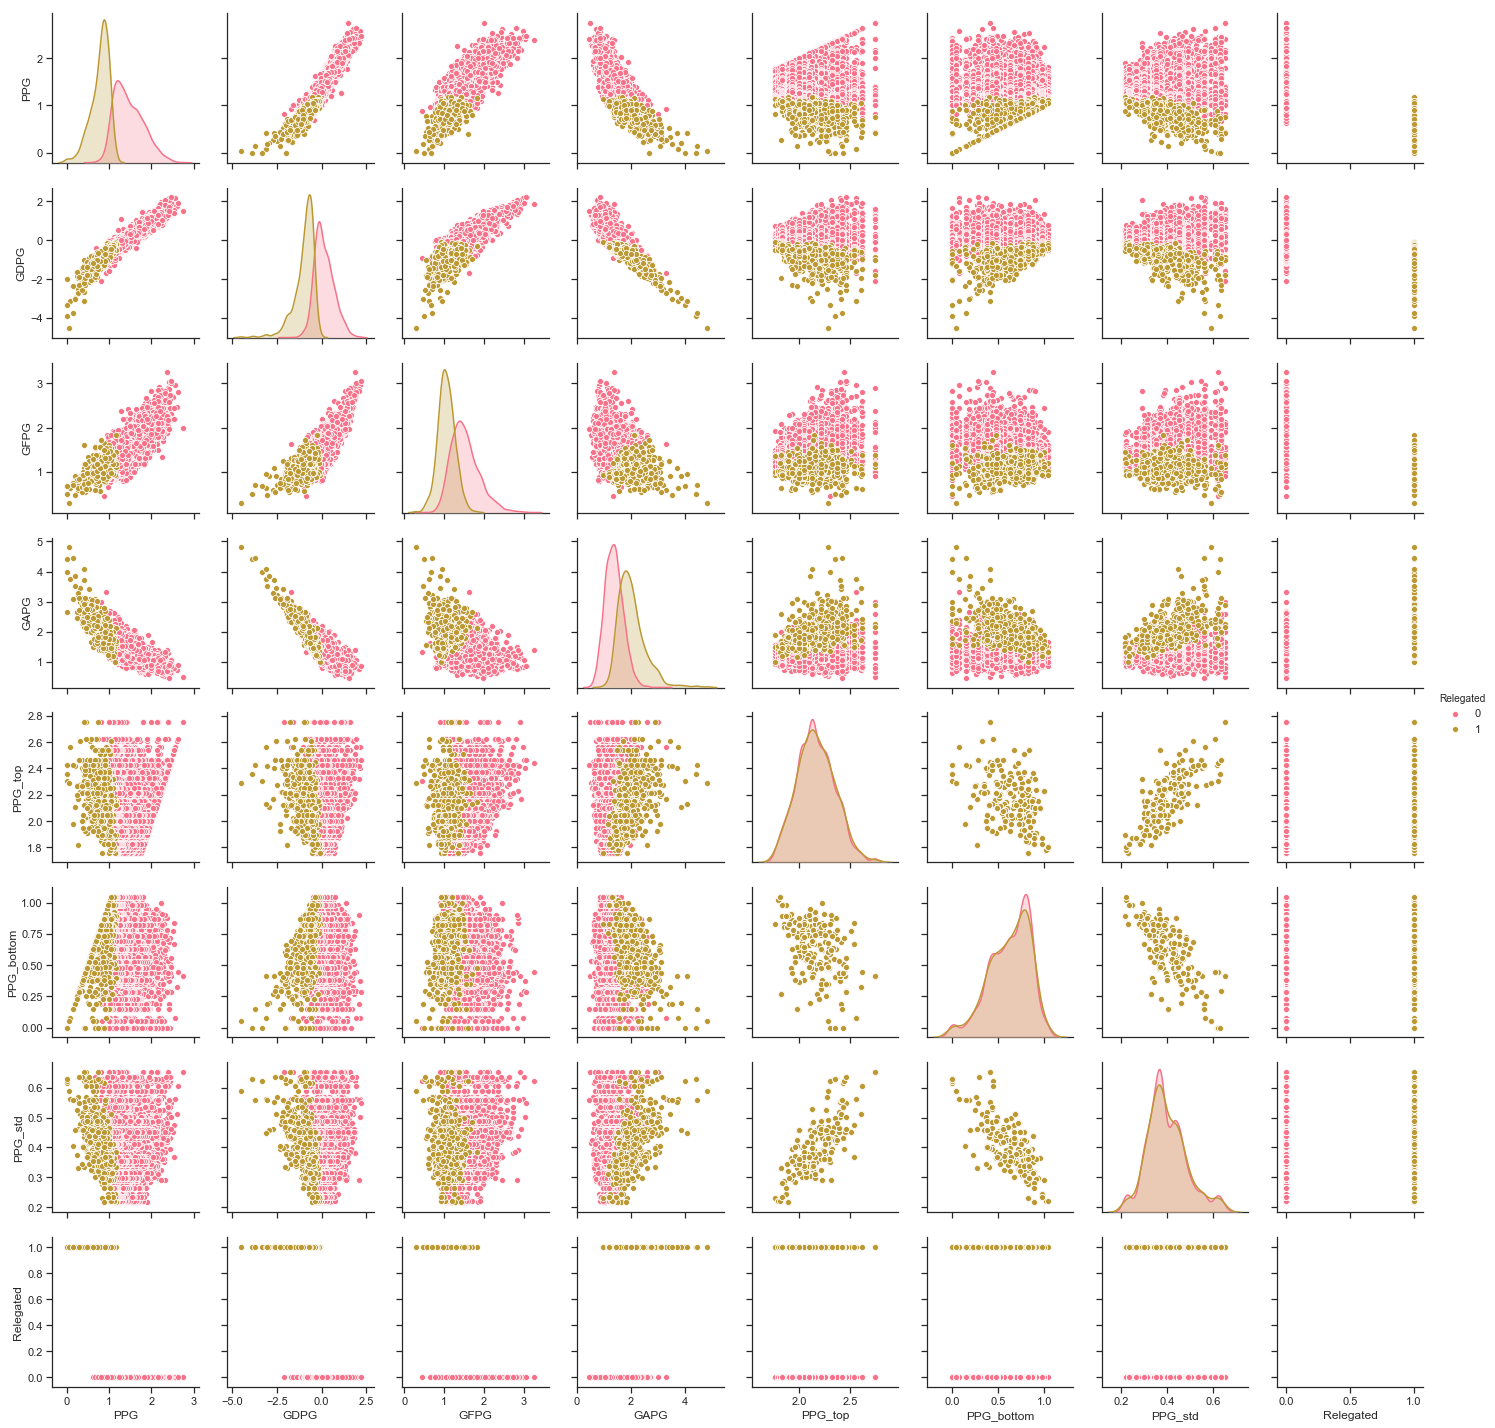

In [25]:
import seaborn as sns
sns.set(style="ticks")
sns.set_palette("husl")
sns.pairplot(df_teams.iloc[:,8:16],hue="Relegated")

### See how this compares to a basic code solution

In [26]:
def code_predict(test_data, threshold):
    predict = []
    for team in test_data:
        if team[0] > threshold:
            #predict.append([1,0])
            predict.append(0)
        else:
            #predict.append([0,1])
            predict.append(1)
    return predict


def get_prediction_accuracy(test_data, test_labels, threshold):
    code_predictions = code_predict(test_data, threshold)
    cm = confusion_matrix(test_labels, code_predictions, labels=[0,1])
    #print(cm)
    errors = cm[0][1] + cm[1][0]
    correct = cm[0][0] + cm[1][1]
    accuracy = correct / (errors + correct) * 100
    return (threshold, accuracy)
    


94.99637418419144
Confusion matrix, without normalization
[[1188   14]
 [  55  122]]
Normalized confusion matrix
[[0.98835275 0.01164725]
 [0.31073446 0.68926554]]


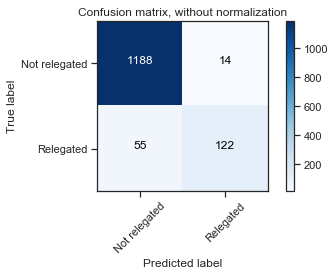

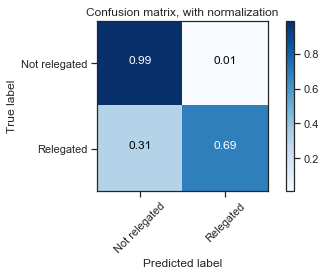

In [27]:
step = 0.001
i = 0.5
best_accuracy = 0
best_threshold = 0
while i < 3:
    threshold, accuracy = get_prediction_accuracy(X_test, y_test_class, i)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_threshold = threshold
    i = i + step
    
print(get_prediction_accuracy(X_test, y_test_class, best_threshold)[1])

cm = confusion_matrix(y_test_class, code_predict(X_test, best_threshold), labels=[0,1])
plot_confusion_matrix(cm, classes=['Not relegated','Relegated'],
                      title='Confusion matrix, without normalization')
plt.figure()
plot_confusion_matrix(cm, classes=['Not relegated','Relegated'], normalize=True,
                      title='Confusion matrix, with normalization')